The preprocessed dataset is being created from Huwaei Private Cloud 2023 from following directories
    <li>1. Requests Per Minute </li>
    <li>2. CPU Usage Per Minute </li>
    <li>3. Memory Usage Per Minute </li>

### NBEATS

In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import NBEATSModel, TCNModel  # You can try other models like TFTModel, TransformerModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np

/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [3]:
df = df.fillna(method='ffill', axis=1).fillna(0)

/tmp/ipykernel_40294/3304020842.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill', axis=1).fillna(0)


In [4]:
# Normalize the data (optional but recommended)
scaler_target = Scaler(MinMaxScaler())
scaler_covariates = Scaler(MinMaxScaler())

# Convert to Darts TimeSeries
series_target = TimeSeries.from_dataframe(df, value_cols=["requests"]).astype(np.float32)
series_covariates = TimeSeries.from_dataframe(df, value_cols=["memory", "cpu"]).astype(np.float32)

# Normalize
series_target = scaler_target.fit_transform(series_target)
series_covariates = scaler_covariates.fit_transform(series_covariates)


In [5]:
# Define train-test split
train_size = 0.8  # 80% training, 20% testing
train_target, test_target = series_target.split_after(train_size)
train_covariates, test_covariates = series_covariates.split_after(train_size)


In [6]:
window = 11
prediction_length = 2 # one step forecast
eps = 50

In [7]:
tcnmodel = TCNModel(
    input_chunk_length=window,
    output_chunk_length=prediction_length,
    random_state=42,
    pl_trainer_kwargs={"accelerator": "gpu" if torch.cuda.is_available() else "cpu"}
)

tcnmodel.fit(train_target, past_covariates=train_covariates, epochs=eps, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 104    | train
--------------------

Epoch 49: 100%|██████████| 180/180 [00:01<00:00, 166.74it/s, train_loss=1.84e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 180/180 [00:01<00:00, 166.62it/s, train_loss=1.84e-5]


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=11, output_chunk_length=2, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu'})

In [8]:
# Initialize the model (you can also try TransformerModel, TFTModel, RNNModel, etc.)
nbeatsModel = NBEATSModel(
    input_chunk_length=window,   # Number of past time steps to use
    output_chunk_length=prediction_length,  # Number of future steps to predict
    random_state=42,
    pl_trainer_kwargs={"accelerator": "gpu" if torch.cuda.is_available() else "cpu"}
)

nbeatsModel.fit(series=train_target, past_covariates=train_covariates, epochs=eps, verbose=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.3 M  | train
-------------------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.066    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 180/180 [00:06<00:00, 25.97it/s, train_loss=2.46e-5] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 180/180 [00:06<00:00, 25.96it/s, train_loss=2.46e-5]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=11, output_chunk_length=2, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu'})

In [9]:
test_covariates_extended = series_covariates[-(len(test_target) + nbeatsModel.input_chunk_length):]

#nbeats model predcition
nbeats_pred_series = nbeatsModel.predict(n=len(test_target),past_covariates=test_covariates_extended)

#tcn model prediction
tcn_pred_series = tcnmodel.predict(n=len(test_target), past_covariates=test_covariates_extended)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


### Evaluation Part

 Inverting back to original values for evaluating metrics

In [10]:
tcn_pred_original = scaler_target.inverse_transform(tcn_pred_series)
nbeats_pred_original = scaler_target.inverse_transform(nbeats_pred_series)
test_target_original = scaler_target.inverse_transform(test_target)

In [11]:
from darts.metrics import mse, rmse, mae, r2_score, mape

def evaluate_forecast(true_series, pred_series):
    results = {
        "MSE": mse(true_series, pred_series),
        "RMSE": rmse(true_series, pred_series),
        "MAE": mae(true_series, pred_series),
        "MAPE": mape(true_series, pred_series),
        "R2": r2_score(true_series, pred_series)
    }
    return results


In [12]:
results_tcn = evaluate_forecast(test_target_original, tcn_pred_original)    
results_nbeats = evaluate_forecast(test_target_original, nbeats_pred_original)  

In [13]:
results_tcn, results_nbeats

({'MSE': 152551.62,
  'RMSE': 390.57858,
  'MAE': 101.27295,
  'MAPE': 206.2617,
  'R2': 0.020369232},
 {'MSE': 203780.98,
  'RMSE': 451.42108,
  'MAE': 238.76743,
  'MAPE': 409.5961,
  'R2': -0.30860698})

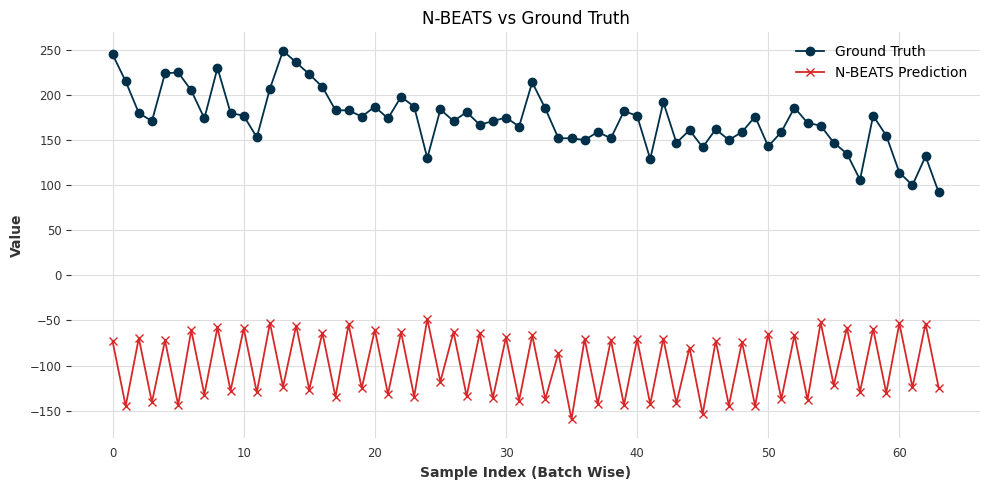

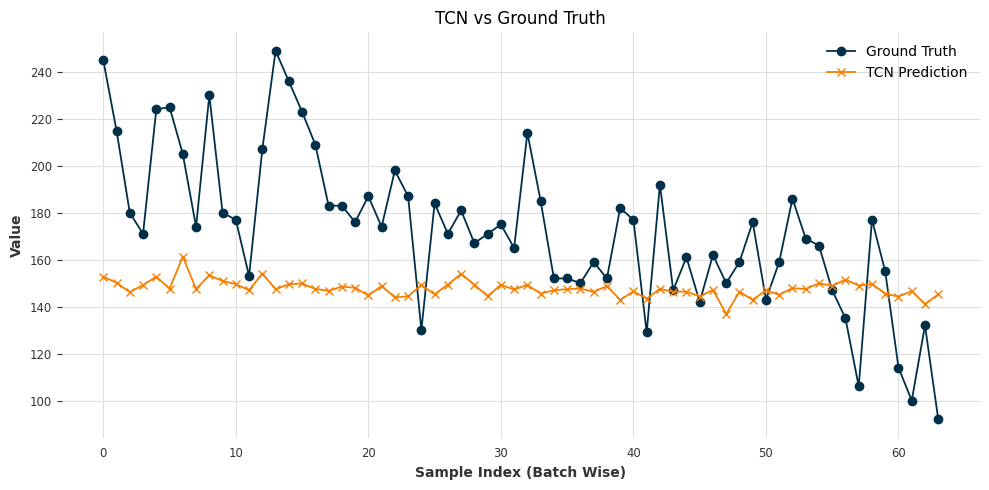

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Only take the last 64 values
n = 64
x = np.arange(n)  # Sample indices

# Safely convert and flatten regardless of source
gt = test_target_original[-n:].values().flatten()
nbeats = nbeats_pred_original[-n:].values().flatten()
tcn = tcn_pred_original[-n:].values().flatten()


# Plot for N-BEATS
plt.figure(figsize=(10, 5))
plt.plot(x, gt, label="Ground Truth", marker='o', color='#003049')
plt.plot(x, nbeats, label="N-BEATS Prediction", marker='x', color='#d62828')
plt.title("N-BEATS vs Ground Truth")
plt.xlabel("Sample Index (Batch Wise)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for TCN
plt.figure(figsize=(10, 5))
plt.plot(x, gt, label="Ground Truth", marker='o', color='#003049')
plt.plot(x, tcn, label="TCN Prediction", marker='x', color='#f77f00')
plt.title("TCN vs Ground Truth")
plt.xlabel("Sample Index (Batch Wise)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ARIMA

In [15]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])

In [16]:
# did the forward fill
df = df.fillna(method='ffill', axis=1).fillna(0)

/tmp/ipykernel_40294/2194621746.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill', axis=1).fillna(0)
/tmp/ipykernel_40294/2194621746.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(method='ffill', axis=1).fillna(0)


### find the p,q,d values for ARIMA

Function for determining whether data is stationary or not

In [17]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

time_series = df['requests']
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    if result[1] < 0.05:
        print("Conclusion: The series is stationary (d=0).")
    else:
        print("Conclusion: The series is NOT stationary. Differencing required (d=1).")

# Run ADF test
adf_test(time_series)

ADF Statistic: -8.648601773009144
p-value: 5.188668010411974e-14
Critical Values:
	1%: -3.43126312739421
	5%: -2.8619435304007217
	10%: -2.5669847951004168
Conclusion: The series is stationary (d=0).


PACF Plot for determining p

<Figure size 1200x500 with 0 Axes>

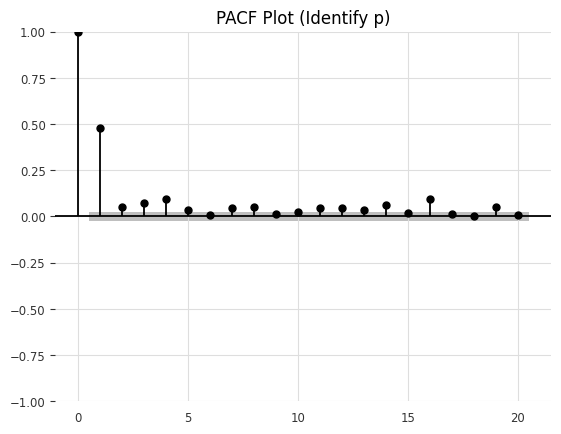

In [18]:
plt.figure(figsize=(12, 5))
plot_pacf(df['requests'], lags=20)
plt.title("PACF Plot (Identify p)")
plt.show()

p = 3 have largest spike, so p = 3

<Figure size 1200x500 with 0 Axes>

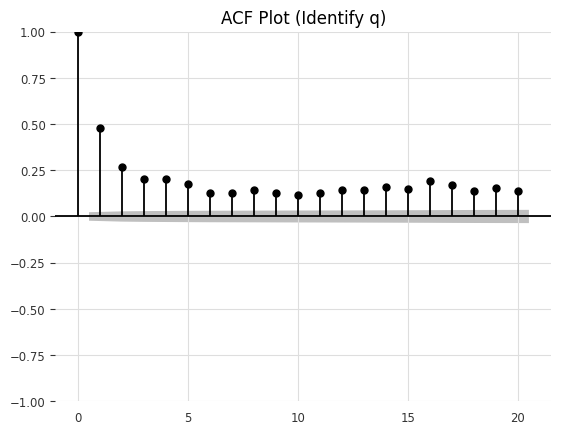

In [19]:
plt.figure(figsize=(12, 5))
plot_acf(df['requests'], lags=20)
plt.title("ACF Plot (Identify q)")
plt.show()

there is not much difference in spikes, so just choose q = 0

In [20]:
# Ensure time is the index
df.set_index('timestamp', inplace=True)

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(df) * 0.8)  # 80% data for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

Using library for dynamically determining the values of p, q and d

In [21]:
import pmdarima as pm

auto_model = pm.auto_arima(train['requests'], seasonal=False, stepwise=True, suppress_warnings=True,error_action="ignore")

print(auto_model.order)  # (p, d, q)


/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

(1, 1, 1)


In [22]:
# Train ARIMA Model
arima_model = ARIMA(train['requests'], order=(1,0,1)).fit()

# Forecast
arima_forecast = arima_model.forecast(len(test))

/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


In [23]:
import numpy as np

# Function to compute evaluation metrics including R^2 and MSE
def evaluate_forecast(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    mse = np.mean((y_true - y_pred) ** 2)   # Mean Squared Error
    rmse = np.sqrt(mse)                     # Root Mean Squared Error
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100  # Mean Absolute Percentage Error

    # R^2 Score (coefficient of determination)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2
    }


In [24]:
metrics = evaluate_forecast(test['requests'], arima_forecast)

In [25]:
print(f"ARIMA Model Metrics:")
print(f"MSE: {metrics['MSE']:.2f}")
print(f"RMSE: {metrics['RMSE']:.2f}")
print(f"MAE: {metrics['MAE']:.2f}")
print(f"MAPE: {metrics['MAPE']:.2f}")
print(f"R^2: {metrics['R2']:.2f}")

ARIMA Model Metrics:
MSE: 159120.93
RMSE: 398.90
MAE: 108.61
MAPE: 176.19
R^2: -0.02


In [26]:
print(arima_forecast[-64:])

2023-10-05 22:56:00    117.379859
2023-10-05 22:57:00    117.379859
2023-10-05 22:58:00    117.379859
2023-10-05 22:59:00    117.379859
2023-10-05 23:00:00    117.379859
                          ...    
2023-10-05 23:55:00    117.379859
2023-10-05 23:56:00    117.379859
2023-10-05 23:57:00    117.379859
2023-10-05 23:58:00    117.379859
2023-10-05 23:59:00    117.379859
Freq: min, Name: predicted_mean, Length: 64, dtype: float64


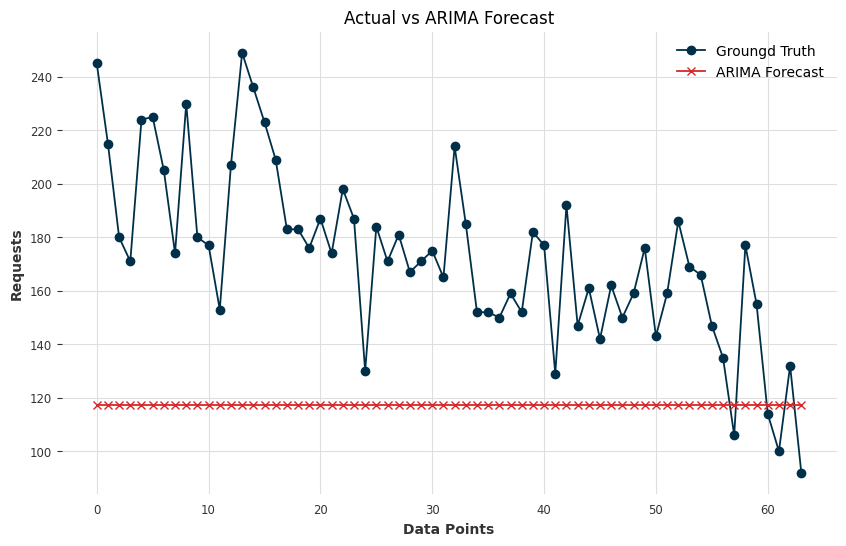

In [27]:
import matplotlib.pyplot as plt

n = 64
x = np.arange(n) 

# Assuming test['requests'] and arima_forecast are pandas Series
plt.figure(figsize=(10, 6))

plt.plot(x, test['requests'][-64:], label='Groungd Truth', marker='o', color='#003049') 
plt.plot(x, arima_forecast[-64:], label='ARIMA Forecast', marker='x', color='#d62828')

plt.title('Actual vs ARIMA Forecast')
plt.xlabel('Data Points')
plt.ylabel('Requests')
plt.legend()
plt.grid(True)
plt.show()


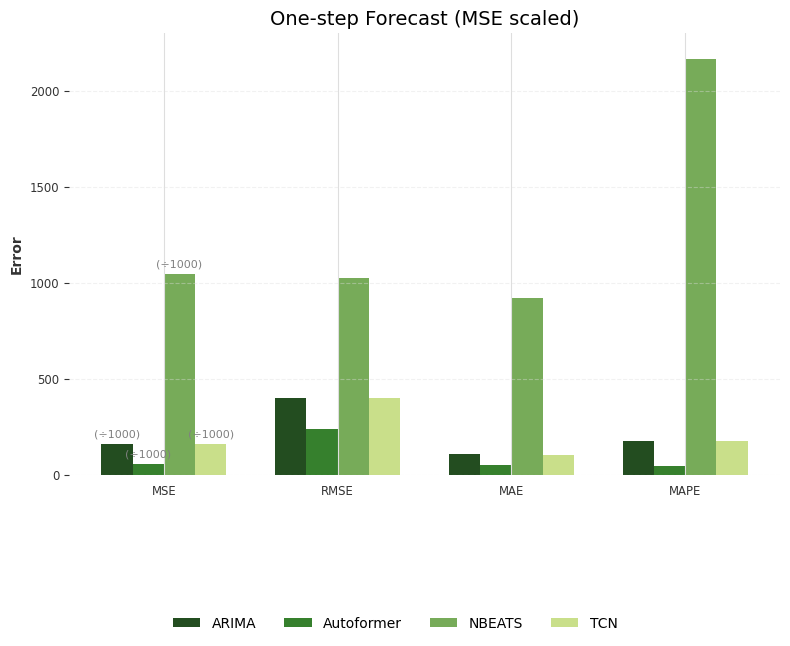

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# One-step forecast data
metrics = ['MSE', 'RMSE', 'MAE', 'MAPE']
models = ['ARIMA', 'Autoformer', 'NBEATS', 'TCN']
data = np.array([
    [159120.93, 398.90, 108.61, 176.19],    
    [58312.84, 241.48, 52.88, 46.47],       
    [1046825.25, 1023.144, 920.146, 2163.98],
    [160699.03, 400.87, 104.83, 178.88]     
])

# Scale MSE down by 1000
scaling_factor = 1000
data[:, 0] = data[:, 0] / scaling_factor  # scale MSE

# One color per model
model_colors = ['#234d20', '#36802d', '#77ab59', '#c9df8a']

x = np.arange(len(metrics))
bar_width = 0.18

fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars grouped by metric, colored by model
for i in range(len(models)):
    bars = ax.bar(x + (i - 1.5) * bar_width, data[i], width=bar_width, label=models[i], color=model_colors[i])

    # Annotate only MSE bars (first metric group)
    for j, bar in enumerate(bars):
        if j == 0:  # MSE metric only
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 25, "(÷1000)", 
                    ha='center', va='bottom', fontsize=8, color='gray')

ax.set_title('One-step Forecast (MSE scaled)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Error')
ax.set_ylim(0, 2300)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

fig.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.08), frameon=False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


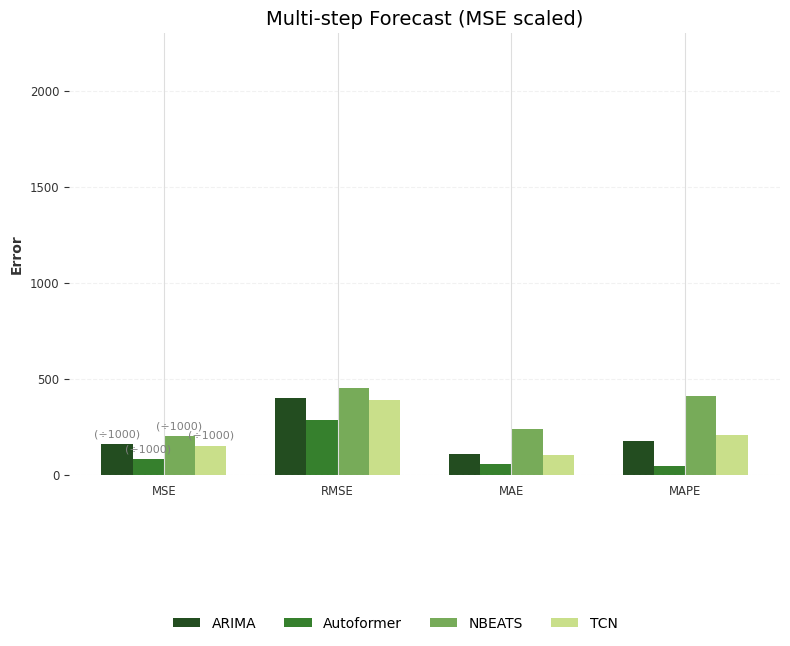

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Multi-step forecast data
metrics = ['MSE', 'RMSE', 'MAE', 'MAPE']
models = ['ARIMA', 'Autoformer', 'NBEATS', 'TCN']
data = np.array([
    [159120.93, 398.90, 108.61, 176.19],    
    [81561.99, 285.59, 56.10, 46.39],       
    [203780.98, 451.42, 238.76, 409.59],
    [152551.62, 390.57, 101.27, 206.26]     
])

# Scale MSE down by 1000
scaling_factor = 1000
data[:, 0] = data[:, 0] / scaling_factor  # scale MSE

# One color per model
model_colors = ['#234d20', '#36802d', '#77ab59', '#c9df8a']

x = np.arange(len(metrics))
bar_width = 0.18

fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars grouped by metric, colored by model
for i in range(len(models)):
    bars = ax.bar(x + (i - 1.5) * bar_width, data[i], width=bar_width, label=models[i], color=model_colors[i])

    # Annotate only MSE bars (first metric group)
    for j, bar in enumerate(bars):
        if j == 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 25, "(÷1000)", 
                    ha='center', va='bottom', fontsize=8, color='gray')

ax.set_title('Multi-step Forecast (MSE scaled)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Error')
ax.set_ylim(0, 2300)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

fig.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.08), frameon=False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()
